# RIAA Filter
This investigates different implementations of the [RIAA equalization](https://en.wikipedia.org/wiki/RIAA_equalization)

It investigates a forum post that came up with a set of RIAA parameters from reverse-engineering an analog design. It then traces these parameters to the source-code of `sox`, a
[Cross-platform Audio-Editing software](https://en.wikipedia.org/wiki/SoX)

[Official sox homepage](http://sox.sourceforge.net/)

We finally try to derive the correct RIAA parameters.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
%matplotlib inline

In [2]:
def plot_response(w, h, title = 'Frequency response', f0 = None, log = False, lin = False) :
    fig = plt.figure ()
    ax1 = fig.add_subplot (111)
    if log :
        ax1.set_xscale ('log')
    plt.title (title)
    xlabel = 'Freq [rad/sample]'
    if f0 is not None :
        w = np.array (w) * f0 / (2 * np.pi)
        xlabel = 'Freq (Hz)'
        if f0 == 1.0 :
            xlabel = '$\\Omega$'
    if lin :
        plt.plot (w, abs (h), 'b')
        plt.ylabel ('Amplitude (lin.)', color = 'b')
    else :
        plt.plot (w, 20 * np.log10 (abs (h)), 'b')
        plt.ylabel ('Amplitude (dB)', color = 'b')
    plt.xlabel (xlabel)
    plt.grid (which = 'both')

    ax2 = ax1.twinx ()
    angles = np.unwrap (np.angle (h))
    plt.plot (w, angles, 'g')
    plt.ylabel ('Angle (rad)', color = 'g')
    plt.axis ('tight')
    plt.show ()

In [3]:
def plot_delay(w, d, title = "Group delay", f0 = None, log = False) :
    fig = plt.figure ()
    ax1 = fig.add_subplot (111)
    if log :
        ax1.set_xscale ('log')
    plt.title (title)
    xlabel = 'Freq [rad/sample]'
    if f0 is not None :
        w = np.array (w) * f0 / (2 * np.pi)
        xlabel = 'Freq (Hz)'
        if f0 == 1.0 :
            xlabel = '$\\Omega$'
    plt.plot (w, d, 'b')
    plt.ylabel ('Delay', color = 'b')
    plt.xlabel (xlabel)

    plt.grid ()
    plt.axis ('tight')
    plt.show ()

In [4]:
def pole_zero_plot (poles, zeros, limit = 1e6) :
    fig = plt.figure ()
    ax1 = fig.add_subplot (111)
    poles = np.array (poles)
    zeros = np.array (zeros)
    m1 = m2 = 1
    if len (poles) :
        m1 = max (abs (poles))
    if len (zeros) :
        m2 = max (abs (zeros))
    m  = max (m1, m2) + 1
    if m > limit :
        m = limit
    plt.plot(np.real(zeros), np.imag(zeros), 'ob')
    plt.plot(np.real(poles), np.imag(poles), 'xr')
    plt.legend(['Zeros', 'Poles'], loc=2)
    plt.title('Pole / Zero Plot')
    plt.ylabel('Real')
    plt.xlabel('Imag')
    plt.grid()
    plt.xlim (-m, m)
    plt.ylim (-m, m)
    plt.gca ().set_aspect ('equal', adjustable='box')
    plt.show()


In [5]:
def update_conjugate_complex (numbers) :
    """ Modify numbers in-place to add conjugate complex numbers"""
    n2 = [k.conjugate () for k in numbers if k.imag]
    numbers.extend (n2)

### Audacity RIAA parameters
The Software Audacity contains a RIAA curve specified as a list of frequency/gain pairs.
RIAA Parameters (curve) from source-code of
[Audacity](https://www.audacityteam.org/) in the file `presets/EQDefaultCurves.xml`:

In [6]:
# Audacity RIAA curve
audacity_riaa = \
[ (20.00,    19.274)
, (25.00,    18.954)
, (31.00,    18.516)
, (40.00,    17.792)
, (50.00,    16.946)
, (63.00,    15.852)
, (80.00,    14.506)
, (100.00,   13.088)
, (125.00,   11.563)
, (160.00,    9.809)
, (200.00,    8.219)
, (250.00,    6.677)
, (315.00,    5.179)
, (400.00,    3.784)
, (500.00,    2.648)
, (630.00,    1.642)
, (800.00,    0.751)
, (1000.00,   0.000)
, (1250.00,  -0.744)
, (1600.00,  -1.643)
, (2000.00,  -2.589)
, (2500.00,  -3.700)
, (3150.00,  -5.038)
, (4000.00,  -6.605)
, (5000.00,  -8.210)
, (6300.00,  -9.980)
, (8000.00,  -11.894)
, (10000.00, -13.734)
, (12500.00, -15.609)
, (16000.00, -17.708)
, (20000.00, -19.620)
, (25000.00, -21.542)
, (48000.00, -27.187)
]

def compare_to_audacity (a, b, fs) :
    aud_frq = np.array (list (k for k, v in audacity_riaa if k <= fs / 2))
    aud_db  = np.array (list (v for k, v in audacity_riaa if k <= fs / 2))
    
    frq = aud_frq / fs * 2 * np.pi
    w, h = signal.freqz (b, a, frq)
    db = 20 * np.log10 (abs (h))
    
    fig = plt.figure ()
    ax1 = fig.add_subplot (111)
    ax1.set_xscale ('log')
    plt.title ('Gain Error @%s kHz' % (fs / 1000))
    
    plt.plot (aud_frq, db - aud_db, 'b')
    plt.ylabel ('Amplitude Difference (dB)', color = 'b')
    plt.xlabel ('Freq (Hz)')
    plt.grid (which = 'both')

    #for adb, ndb, f in zip (aud_db, db, aud_frq) :
    #    if f > fs / 2 :
    #        break
    #    print ("%s %s %s %s" % (f, adb, ndb, abs (ndb - adb)))

[Forum Post](https://www.musicdsp.org/en/latest/Filters/122-digital-riaa-equalization-filter-coefficients.html)
Claims the following:

    The s-domain transfer function is

    R3(1+R1*C1*s)(1+R2*C2*s)/(R1(1+R2*C2*s) + R2(1+R1*C1*s) +
    R3(1+R1*C1*s)(1+R2*C2*s))

    where
    `R1 = 883.3k`
    `R2 = 75k`
    `R3 = 604`
    `C1 = 3.6n`
    `C2 = 1n`
    This is based on the reference circuit found in http://www.hagtech.com/pdf/riaa.pdf
    The coefficients of the digital transfer function `b(z^-1)/a(z^-1)`
    in descending powers of z, are:

Note: This is the *inverse* RIAA (for recording not for playback)
and one of 44.1 kHz or 48 kHz is wrong (they're identical).
Also note that the analog circuit that was used as a basis of
reverse engineering claims that in the original recording
equipment there was a pole at 3.18µs (about 50kHz). This has been
disputed in 2009 in an
[article by Keith Howard in "stereophile"](https://www.stereophile.com/content/cut-and-thrust-riaa-lp-equalization-page-2)

The analog circuit realizing this pole for playback by Jim Hagerman in linked here:
[Link to analog circuit](http://www.hagtech.com/pdf/riaa.pdf)

Parameters from the forum post for recording:

#### 44.1kHz
```
b = [ 0.02675918611906  -0.04592084787595   0.01921229297239]
a = [ 1.00000000000000  -0.73845850035973  -0.17951755477430]
error +/- 0.25dB
```
#### 48kHz
```
b = [  0.02675918611906  -0.04592084787595   0.01921229297239]
a = [  1.00000000000000  -0.73845850035973  -0.17951755477430]
error +/- 0.15dB
```
#### 88.2kHz
```
b = [  0.04872204977233  -0.09076930609195   0.04202280710877]
a = [ 1.00000000000000  -0.85197860443215  -0.10921171201431]
error +/- 0.01dB
```
#### 96kHz
```
b = [ 0.05265477122714  -0.09864197097385   0.04596474352090  ]
a = [  1.00000000000000  -0.85835597216218  -0.10600020417219 ]
error +/- 0.006dB
```

Later post in same forum thread:

    FYI, here are working filter coefficients for biquad implementation
    of RIAA EQ Reproduction filters:

An the paramters, now with *different* sets for 44.1kHz and 48kHz:

#### 44.1kHz:
```
a = [ 1.0000000000 -1.7007240000  0.7029381524 ]
b = [ 1.0000000000 -0.7218922000 -0.1860520545 ]
error ~0.23dB
```
#### 48kHz:
```
a = [ 1.0000000000 -1.7327655000  0.7345534436 ]
b = [ 1.0000000000 -0.7555521000 -0.1646257113 ]
error ~0.14dB
```
#### 88.2kHz:
```
a = [ 1.0000000000 -1.8554648000  0.8559721393 ]
b = [ 1.0000000000 -0.8479577000 -0.1127631993 ]
error 0.008dB
```
#### 96kHz:
```
a = [ 1.0000000000 -1.8666083000  0.8670382873 ]
b = [ 1.0000000000 -0.8535331000 -0.1104595113 ]
error ~0.006dB
```
```
#### NOTES in Forum:
All these given filter coefficients produces a bit gained filter
(~+12.5dB or so) so, if you like to adjust the 1 kHz = 0dB, it can
be done quite accurately by finding linear difference using software
like Tobybear's FilterExplorer. Enter coefficients into
FilterExplorer, by moving mouse cursor over the plotted magnitude
curve in magnitude plot window, find/point the ~1kHz position and
then check the magnitude value (value inside the brackets) found in
info field. Use this value as divider for b coefficients.

#### Notes (by me):
It looks like the original analog circuit that was reverse-engineered
here has a pole at around 50kHz. To make such a high frequency pole
work the system must have a sampling rate of > 100kHz. So for all these
lower sampling rates the pole will be aliased (!) to a lower frequency.

In the following we check these parameters and print the zeros and
poles for this configuration.

In [7]:
# Coefficients from the forum post.
# Note that either the 44.1 or the 48 kHz value is bogus
# These are the *recording* values not the playback values
riaa = \
{   '44.1' :
    dict
        ( b = [0.02675918611906, -0.04592084787595,  0.01921229297239]
        , a = [1.00000000000000, -0.73845850035973, -0.17951755477430]
        )
,   '48.0' :
    dict
        ( b = [0.02675918611906, -0.04592084787595,  0.01921229297239]
        , a = [1.00000000000000, -0.73845850035973, -0.17951755477430]
        )
,   '88.2' :
    dict
        ( b = [0.04872204977233, -0.09076930609195,  0.04202280710877]
        , a = [1.00000000000000, -0.85197860443215, -0.10921171201431]
        )
,   '96.0' :
    dict
        ( b = [0.05265477122714, -0.09864197097385,  0.04596474352090]
        , a = [1.00000000000000, -0.85835597216218, -0.10600020417219]
        )
}
for k in riaa :
    d = riaa [k]
    d ['w'], d ['h'] = signal.freqz (d ['b'], d ['a'])
    d ['wg'], d ['gd'] = signal.group_delay ((d ['b'], d ['a']))
    z, p, g = signal.tf2zpk (d ['b'], d ['a'])
    print ("zeros:", z, "poles:", p, "gain:", g)

zeros: [0.9931716 0.7229063] poles: [ 0.93123263 -0.19277413] gain: 0.02675918611906
zeros: [0.9931716 0.7229063] poles: [ 0.93123263 -0.19277413] gain: 0.02675918611906
zeros: [1.00356989 0.85943272] poles: [ 0.96513548 -0.11315687] gain: 0.04872204977233
zeros: [1.00328287 0.87008907] poles: [ 0.96787451 -0.10951854] gain: 0.05265477122714


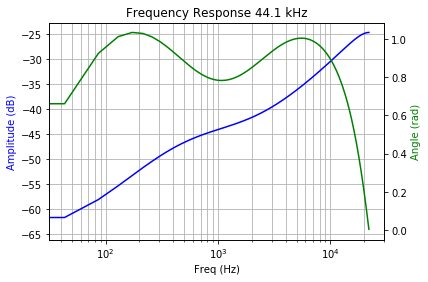

In [8]:
plot_response (riaa ['44.1']['w'], riaa ['44.1']['h'], 'Frequency Response 44.1 kHz', 44100, log = True)

In the following we have the parameters for *playback* from the forum post.
Note that when displaying the poles at the end we have

In [9]:
# Later in same forum post, these are the playback values
riaa = \
{   '44.1' :
    dict
        ( a = [ 1.0000000000, -1.7007240000,  0.7029381524 ]
        , b = [ 1.0000000000, -0.7218922000, -0.1860520545 ]
        )
,   '48.0' :
    dict
        ( a = [ 1.0000000000, -1.7327655000,  0.7345534436 ]
        , b = [ 1.0000000000, -0.7555521000, -0.1646257113 ]
        )
,   '88.2' :
    dict
        ( a = [ 1.0000000000, -1.8554648000,  0.8559721393 ]
        , b = [ 1.0000000000, -0.8479577000, -0.1127631993 ]
        )
,   '96.0' :
    dict
        ( a = [ 1.0000000000, -1.8666083000,  0.8670382873 ]
        , b = [ 1.0000000000, -0.8535331000, -0.1104595113 ]
        )
}
for k in riaa :
    d = riaa [k]
    d ['w'], d ['h'] = signal.freqz (d ['b'], d ['a'])
    d ['wg'], d ['gd'] = signal.group_delay ((d ['b'], d ['a']))
    d ['zero'], d ['pole'], d ['gain'] = signal.tf2zpk (d ['b'], d ['a'])
    print ("zeros:", d ["zero"], "poles:", d ["pole"], "gain:", d ["gain"])


zeros: [ 0.923382  -0.2014898] poles: [0.9924091 0.7083149] gain: 1.0
zeros: [ 0.932159  -0.1766069] poles: [0.993133  0.7396325] gain: 1.0
zeros: [ 0.9648312 -0.1168735] poles: [0.9964002 0.8590646] gain: 1.0
zeros: [ 0.9676817 -0.1141486] poles: [0.9966946 0.8699137] gain: 1.0


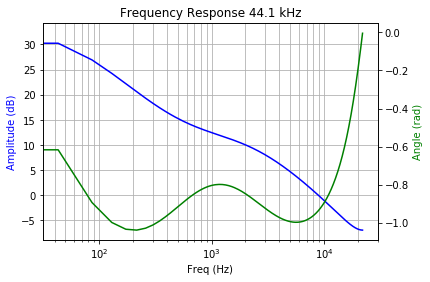

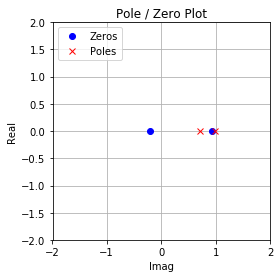

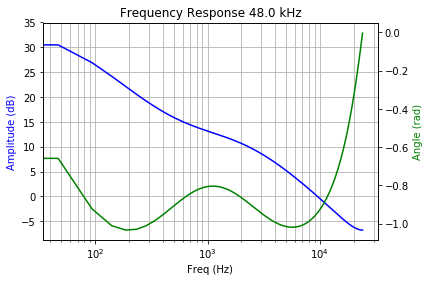

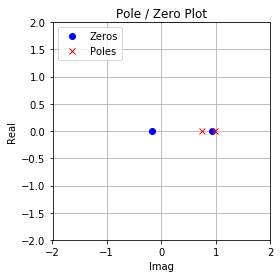

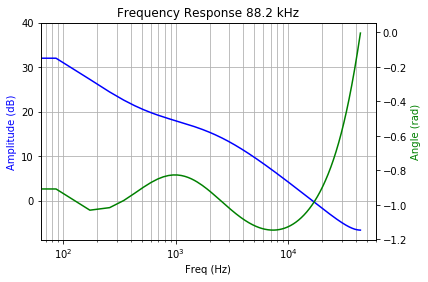

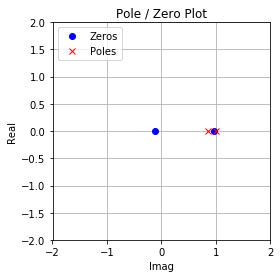

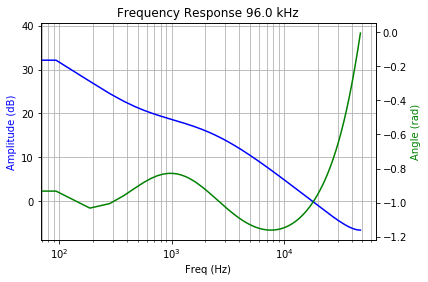

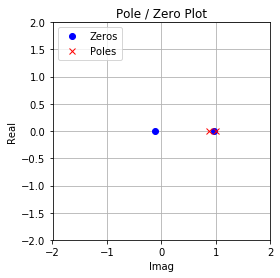

In [10]:
for k in riaa :
    d = riaa [k]
    plot_response (d ['w'], d ['h'], 'Frequency Response %s kHz' % k, f0 = 1000 * float (k), log=1)
    pole_zero_plot (d ['pole'], d ['zero'])
    #plot_delay (d ['wg'], d ['gd'], title = 'Group delay %s kHz' % k, f0 = 1000 * float (k), log=1)

## Source Code from `sox`
[RIAA equalization:](https://en.wikipedia.org/wiki/RIAA_equalization)
Coefficients taken from sox source-code in file `biquads.c`, this
has different polynomials for different sampling rates.

Note that the python-code below with comment
starting "Check that RIAA params..." checks that the a/b
parameters match with the parameters from the forum post
above. So it seems that the sox parameters are derived
from that forum post or some other source that has its
origing there.

We are normalizing the paramters so that the gain @1kHz
is 0dB as specified in the RIAA spec (or at least in what
Wikipedia has about the spec). As you can seen in the plots
the different curves for the different sampling frequencies
do not match.

Digital Gain: 0.23806122326320717 Gain @1kHz: 1.0


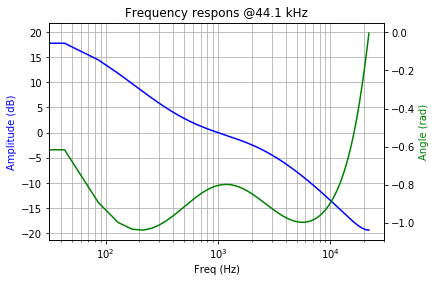

a: [ 1.         -1.700724    0.70293815] b: [ 0.23806122 -0.17185454 -0.04429178]
zeros: [-0.2014898, 0.923382] poles: [0.7083149, 0.9924091]
Digital Gain: 0.21973782308586043 Gain @1kHz: 1.0000000000000002


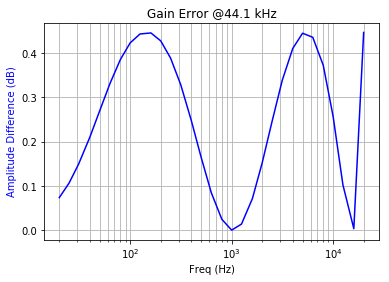

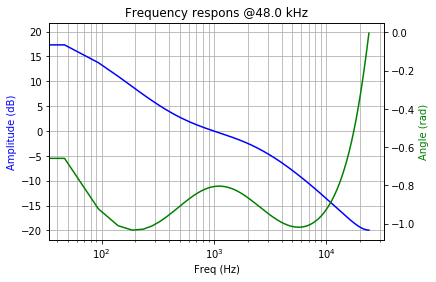

a: [ 1.         -1.7327655   0.73455344] b: [ 0.21973782 -0.16602337 -0.0361745 ]
zeros: [-0.1766069, 0.932159] poles: [0.7396325, 0.993133]
Digital Gain: 0.12671063520519438 Gain @1kHz: 1.0000000000000002


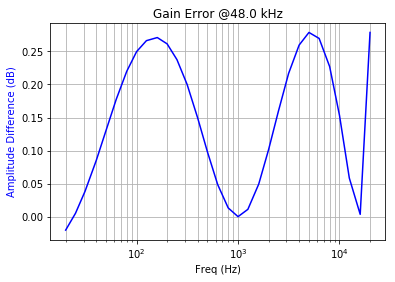

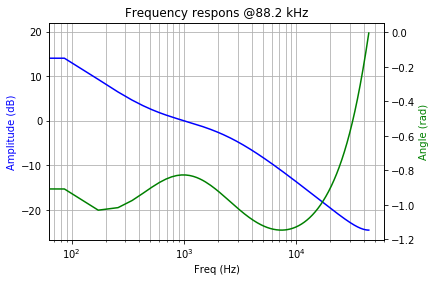

a: [ 1.         -1.8554648   0.85597214] b: [ 0.12671064 -0.10744526 -0.0142883 ]
zeros: [-0.1168735, 0.9648312] poles: [0.8590646, 0.9964002]
Digital Gain: 0.11714782103050884 Gain @1kHz: 1.0000000000000004


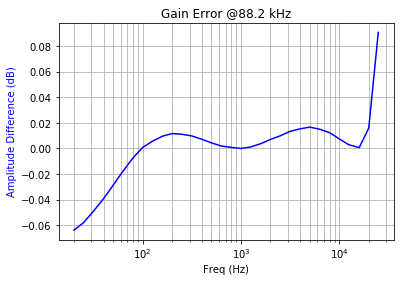

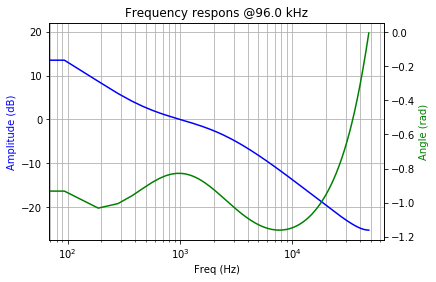

a: [ 1.         -1.8666083   0.86703829] b: [ 0.11714782 -0.09998954 -0.01294009]
zeros: [-0.1141486, 0.9676817] poles: [0.8699137, 0.9966946]


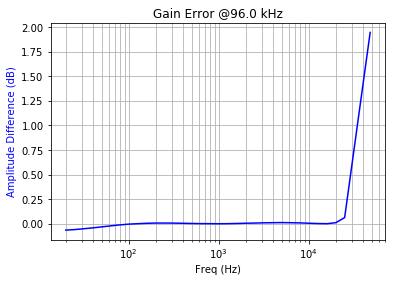

In [11]:
# Values from source-code of sox
sox_riaa = {}
sox_riaa ['44.1'] = dict \
    ( zero = [-0.2014898, 0.9233820]
    , pole = [ 0.7083149, 0.9924091]
    )
sox_riaa ['48.0'] = dict \
    ( zero = [-0.1766069, 0.9321590]
    , pole = [ 0.7396325, 0.9931330]
    )
sox_riaa ['88.2'] = dict \
    ( zero = [-0.1168735, 0.9648312]
    , pole = [ 0.8590646, 0.9964002]
    )
sox_riaa ['96.0'] = dict \
    ( zero = [-0.1141486, 0.9676817]
    , pole = [ 0.8699137, 0.9966946]
    )

# Check that RIAA params from forum are identical with sox params
for k in riaa :
    for zp in 'zero', 'pole' :
        for n1, n2 in zip (sorted (sox_riaa [k][zp]), sorted (riaa [k][zp])) :
            #print (n1, n2, n1 - n2)
            assert abs (n1 - n2) < 5e-10

(b, a) = signal.zpk2tf (sox_riaa ['44.1']['zero'], sox_riaa ['44.1']['pole'], 1.0)
w, h = signal.freqz (b, a)
wg, gd = signal.group_delay ((b, a))
#plot_response (w, h, f0=44100, log = True)

# Normalize to 0dB for 1kHz
digital_gain = 1.0
for rk in sox_riaa :
    sr = sox_riaa [rk]
    fs = float (rk) * 1000.0
    z1kHz = 1000.0 / fs * 2 * np.pi
    for k in range (2) :
        (sr ['nb'], sr ['na']) = signal.zpk2tf (sr ['zero'], sr ['pole'], digital_gain)
        w, h = signal.freqz (sr ['nb'], sr ['na'], [z1kHz])
        #print (w, h, abs (h))
        digital_gain = abs (digital_gain / abs (h [0]))
        #print ("digital gain:", digital_gain)
    print ("Digital Gain:", digital_gain, "Gain @1kHz:", abs (h [0]))
    w, h = signal.freqz (sr ['nb'], sr ['na'])
    plot_response (w, h, f0=fs, log = True, title = 'Frequency respons @%s kHz' % rk)
    print ("a:", sr ['na'], 'b:', sr ['nb'])
    print ("zeros:", sr ['zero'], "poles:", sr ['pole'])
    compare_to_audacity (sr ['na'], sr ['nb'], fs)

### Compute From S-Plane Filter Parameters taken from Wikipedia

Filter: riaa, Sampling Frequency: 44100
zeros: [0.9311756522967054] poles: [0.9928946284742322, 0.7390843975458588]
Digital Gain: 0.26639731824336915 Gain @1kHz: 1.0000000000000002
zeros: [0.9311756522967054] poles: [0.9928946284742322, 0.7390843975458588] gain: 0.26639731824336915
a: [ 1.         -1.73197903  0.73383293] b: [ 0.26639732 -0.2480627 ]


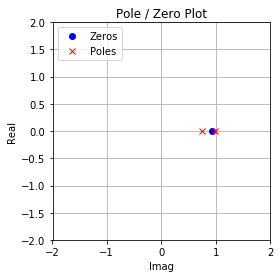

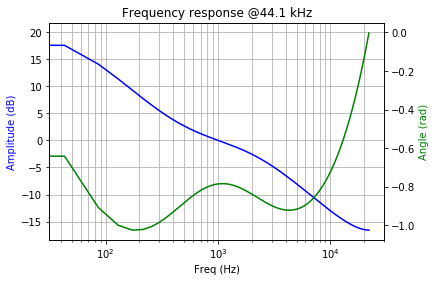


Filter: riaa, Sampling Frequency: 48000
zeros: [0.9365862839664941] poles: [0.9934700507052564, 0.7574651283969664]
Digital Gain: 0.24702604006921136 Gain @1kHz: 1.0
zeros: [0.9365862839664941] poles: [0.9934700507052564, 0.7574651283969664] gain: 0.24702604006921136
a: [ 1.         -1.75093518  0.75251892] b: [ 0.24702604 -0.2313612 ]


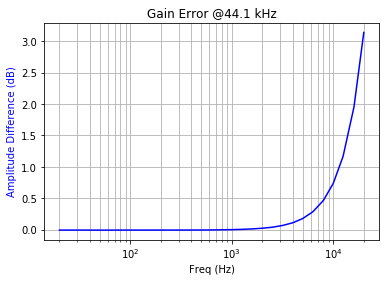

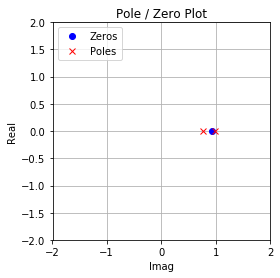

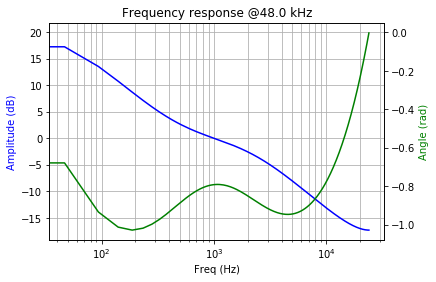


Filter: riaa, Sampling Frequency: 88200
zeros: [0.9649744309030708] poles: [0.9964409809287412, 0.8597001788681091]
Digital Gain: 0.1410786892152778 Gain @1kHz: 0.9999999999999999
zeros: [0.9649744309030708] poles: [0.9964409809287412, 0.8597001788681091] gain: 0.1410786892152778
a: [ 1.         -1.85614116  0.85664049] b: [ 0.14107869 -0.13613733]


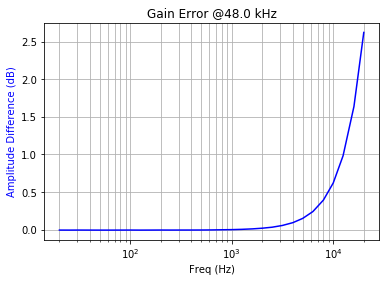

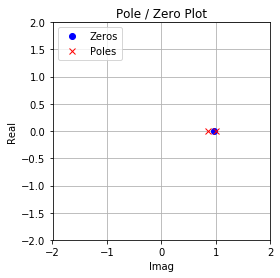

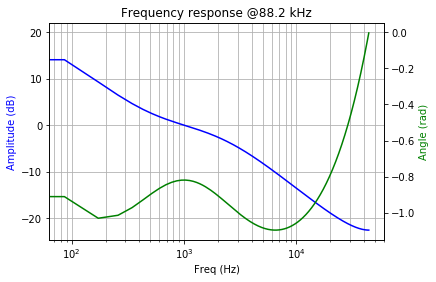


Filter: riaa, Sampling Frequency: 96000
zeros: [0.9677738805973708] poles: [0.996729677849143, 0.8703247258333905]
Digital Gain: 0.1302306391276672 Gain @1kHz: 1.0
zeros: [0.9677738805973708] poles: [0.996729677849143, 0.8703247258333905] gain: 0.1302306391276672
a: [ 1.         -1.8670544   0.86747848] b: [ 0.13023064 -0.12603381]


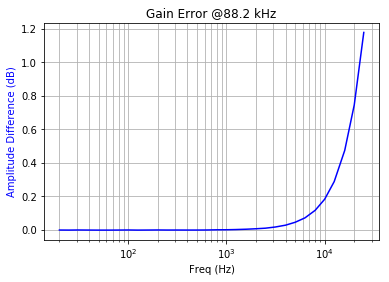

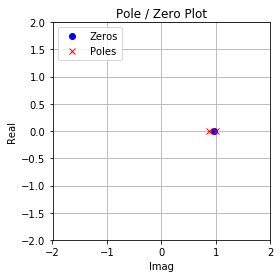

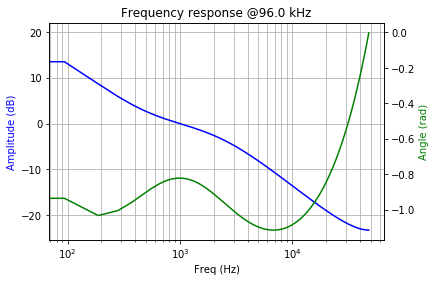

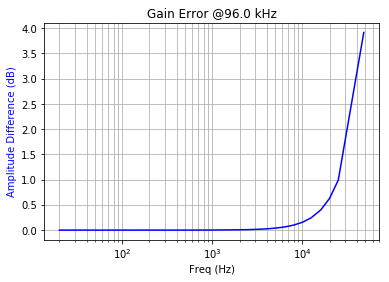

In [12]:
# Parameters from wikipedia
# For now we're only using the riaa parameter set.
# Note that the others are not really tested and the 'flat' set is definitely wrong
riaa = dict (szero = np.array ([318e-6]), spole = np.array ([3180e-6, 75e-6]), name = 'riaa')
bbc  = dict (szero = np.array ([318e-6]), spole = np.array ([3180e-6, 50e-6]), name = 'bbc')
flat = dict (szero = np.array ([319e-6]), spole = np.array ([3180e-6]), name = 'flat')
iec  = dict (szero = np.array ([318e-6]), spole = np.array ([3180e-6, 75e-6, 7950e-6]), name = 'iec')

def PZ (T, fs = 44100) :
    return np.exp ((-1.0 / (T * fs)))

s1kHz = 1.0 / (2 * np.pi * 1000.)
analog_gain = 1.0

for fs in (44100., 48000., 88200., 96000.) :
    for filter in [riaa] :
        print ("Filter: %s, Sampling Frequency: %d" % (filter ['name'], fs))
        # Analog gain = 0dB @ 1kHz
        w, h = signal.freqs_zpk (filter ['szero'], filter ['spole'], analog_gain, [s1kHz])
        #print (w, h, abs (h))
        analog_gain = abs (analog_gain / abs (h [0]))
        #print ("analog gain:", analog_gain)
        w, h = signal.freqs_zpk (filter ['szero'], filter ['spole'], analog_gain, [s1kHz])
        #print ("Gain @1kHz:", abs (h [0]))
        # Plot response of analog filter
        #w, h = signal.freqs_zpk (filter ['szero'], filter ['spole'], analog_gain)
        #plot_response (w, h, title='Frequency %s' % filter ['name'], log=True)

        filter ['zero'] = []
        filter ['pole'] = []
        for z in filter ['szero'] :
            pz = PZ (z, fs)
            filter ['zero'].append (pz)
        for p in filter ['spole'] :
            pz = PZ (p, fs)
            filter ['pole'].append (pz)
        print ('zeros:', filter ['zero'], 'poles:', filter ['pole'])
        
        # Digital gain = 0dB @ 1kHz
        digital_gain = 1.0
        z1kHz = 1000.0 / fs * 2 * np.pi
        for k in range (4) :
            filter ['b'], filter ['a'] = signal.zpk2tf (filter ['zero'], filter ['pole'], digital_gain)
            w, h = signal.freqz (filter ['b'], filter ['a'], [z1kHz])
            digital_gain = abs (digital_gain / abs (h [0]))
        print ("Digital Gain:", digital_gain, "Gain @1kHz:", abs (h [0]))
        filter ['gain'] = digital_gain

        #filter ['zero'], filter ['pole'], filter ['gain'] = \
        #    signal.bilinear_zpk (filter ['szero'], filter ['spole'], analog_gain, fs)
        #filter ['b'], filter ['a'] = signal.zpk2tf (filter ['zero'], filter ['pole'], digital_gain)
        #w, h = signal.freqz (filter ['b'], filter ['a'], [z1kHz])
        #print ("Digital Gain:", filter ['gain'], "Gain @1kHz:", abs (h [0]))

        d = filter
        d ['w'], d ['h'] = signal.freqz (d ['b'], d ['a'])
        d ['wg'], d ['gd'] = signal.group_delay ((d ['b'], d ['a']))
        print ("zeros:", filter ['zero'], "poles:", filter ['pole'], "gain:", filter ['gain'])
        print ('a:', d ['a'], 'b:', d ['b'])
        pole_zero_plot (filter ['pole'], filter ['zero'])
        plot_response (d ['w'], d ['h'], title = "Frequency response @%s kHz" % (fs / 1000), f0 = fs, log=1)
        compare_to_audacity (d ['a'], d ['b'], fs)
        print ()